Hi everyone! It’s been over a year since I first blogged about Julia and why it’s awesome. In this post I want to follow up by comparing it directly with the most popular languages for data science, namely R and Python, starting with their comparatively abysmal performance...

;-)

I'll exemplify on my laptop, a Dell XPS with a Core i7-7700HQ @ 2.80GHz

The algorithm is a golden oldie, namely the [Escape Time Algorithm](https://en.wikipedia.org/wiki/Mandelbrot_set#Escape_time_algorithm) for rendering the [Julia set](https://en.wikipedia.org/wiki/Julia_set) using the quadratic polynomial: $f_c(z)=z^2+c$ and the complex parameter $(\varphi-2) + (\varphi-1)i$

Let's GO!

# Julia 0.6.0

In [45]:
# set the detail level of the fractal
# set the resolution of the resulting bitmap
detail = 1000; h = 6000; w = 6000
bitmap = zeros(h,w)
# this parameter defines the shape of the fractal 
c = (φ-2) + (φ-1)im     # the phi UTF8 character!

function fractal(z, c, lod)
    for i in 1 : lod
        # return the step at which the orbit sequence tends to infinity
        # this usually happens if |z| is greater than 2
        (abs2(z) > 4) ? (return i) : (z = z^2 + c)
    end
    return lod
end

function generate(bitmap, w, h, c, lod)
    for x in 1:w, y in 1:h
        # scale the fractal in proportion to the bitmap
        z = (3*(x-w/2)/w) + (3*(y-h/2)/h)im
        bitmap[y,x] = fractal(z, c, lod) / lod
    end
    return bitmap
end

@time image = generate(bitmap, w, h, c, detail);

  2.575690 seconds (5.75 k allocations: 292.492 KiB)


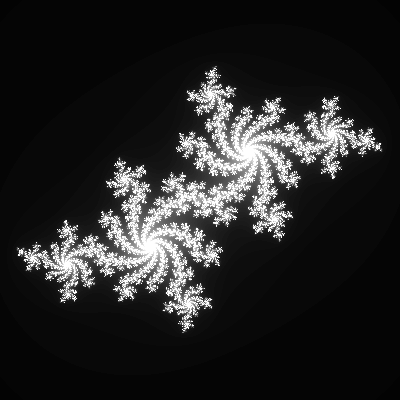

In [43]:
using Colors, Images
Array{Gray24}(image)

The algorithm finished in a bit over __2 seconds__. Sweet.

Let's try the same thing in Python.

# CPython 3.5.2

In [1]:
import time
import numpy as np

detail = 1000; h = 6000; w = 6000
bitmap = np.zeros((h,w))
c = -0.3819660112501051 + 0.6180339887498949j

def fractal(z, c, lod):
    for i in range(lod):
        # this avoids a costly square root computation
        if z.real * z.real + z.imag * z.imag > 4:
            return i
        # z * z is not as good looking as z^2 but a bit faster
        z = z * z + c
    return lod;
        
def generate(bitmap, w, h, c, lod):
    for x, y in np.ndindex(bitmap.shape):
        # too bad we can't just append 'j' to make the second term complex
        z = complex(3*(x+1-w/2)/w, 3*(y+1-h/2)/h)
        bitmap[y,x] = fractal(z, c, lod) / lod           
    return bitmap;
                
t1 = time.time()
image = generate(bitmap, w, h, c, detail)
t0 = time.time()
t0-t1

179.79193115234375

Python took about 3 minutes. It was ~72x slower than Julia. Hmm…

The code is fairly legible in this example, though we see in the double nested loop a preview of the sort of object-oriented syntax that quickly obfuscates mathematical formulas. But we could probably start tweaking it to make it faster right?

We are all taught that to get good performance in R and Python, the ~~code~~ entire algorithm needs to be refactored so that it’s “vectorized”. That way hot code can be offloaded to a faster language (like BLAS functions written in Fortran) without having to make an expensive function call for every element of a data set. This sort of vectorization is not always simple or possible, and when it is possible, it can force you to express algorithms in a contrived way. But before we compare vectorized code with regular code, let’s try running the algorithm again in R.

# R 3.2.3

In [1]:
detail <- 1000; h <- 6000; w <- 6000
bitmap <- matrix(0, h, w)
# support for complex numbers isn't as pretty as it could be
c <- complex(real=-0.3819660112501051,imaginary=0.6180339887498949)

fractal <- function(z, c, max) {
    for (i in 1:max) {
        if (Mod(z) > 2) return(i)
        z <- z^2 + c
    }
    return(max)
}

generate <- function(bitmap, w, h, c, lod) {
    for (x in 1:w) { 
        for (y in 1:h) {
            z <- complex(real=(3*(x-w/2)/w), imaginary=(3*(y-h/2)/h))
            bitmap[x,y] <- fractal(z, c, lod) / lod
        }
    }
    return(bitmap)
}
    
t0 <- Sys.time()
bitmap <- generate(bitmap, w, h, c, detail)
t1 <- Sys.time()
print(t1-t0)   

Time difference of 8.088174 mins


Wow. 8 minutes… That’s a fair bit slower than 2.5 seconds. I remember laughing when I saw a question on Quora asking what statisticians do while their code is running. Well it’s no wonder if R __code is ~200x slower than Julia__! That’s no good. It’s time to pull out our secret weapon: vectorized code!!

In [9]:
detail <- 1000; h <- 6000; w <- 6000
z <- matrix(0.0, h, w)
k <- matrix(0.0, h, w)
x <- seq(0, h)
y <- seq(0, w)
t0 <- Sys.time()
c <- outer(x*-0.3819660112501051,y*0.6180339887498949i,FUN="+")
for (rep in 1:detail) { 
    index <- which(Mod(z) < 2)
    z[index] <- z[index]^2 + c[index]
    k[index] <- k[index] + 1
}
t1 <- Sys.time()
print(t1-t0)

Time difference of 12.24876 mins


12 minutes!!? This was supposed to be faster! Instead it ended up being __~2x slower__ and using __5x more memory__. R spent more time managing memory than doing calculations. :(

Let’s hope Python redeems itself. Here is the Python code rewritten using the vectorization features of numpy.

In [7]:
import time
import numpy as np
detail = 1000; h = 6000; w = 6000

def fractal(c, lod):
    output = np.zeros(c.shape)
    z = np.zeros(c.shape, np.complex64)
    for it in range(lod):
        notdone = np.less(z.real*z.real + z.imag*z.imag, 4.0)
        output[notdone] = it
        z[notdone] = z[notdone]**2 + c[notdone]
    output[output == lod-1] = 0
    return output

def generate(bitmap, w, h, c, lod):
    r1 = np.linspace(-1, 1, w, dtype=np.float32)
    r2 = np.linspace(-1, 1, h, dtype=np.float32)
    c = -0.3819660112501051*r1 + 0.6180339887498949j*r2[:,None]
    bitmap = fractal(c,lod)
    return bitmap.T 
                
t1 = time.time()
image = generate(bitmap, w, h, c, detail)
t0 = time.time()
t0-t1

867.263162612915

14 minutes…….. I guess Python won.

But maybe we can run this algorithm faster by implementing it in TensorFlow, or compiling the loops with numba JIT!! I’m sorry but it’s game over now. These comparisons were meant to illustrate what a data scientist who values their productive time can expect to achieve in short order. So with full knowledge that this blog post does not provide definitive proof of anything, I’m going to present some conclusions:

#### R is absurdly slow 
R code is not just *slowish*... it's positively [glacial](https://www.youtube.com/watch?v=HStF1RJOyxI) compared to other languages. If you're hoping to work with anything other than teeny RAM-sized CSV files, you can pretty much forget about it. Some vendors even have products that spread R code across multiple servers to achieve hIgH sCalaBiliTy. I'm sorry but that just means you have peanut-butter-code running on all your machines instead of one.

#### Python is slow, but passable
Most data scientists only use Python to control the flow of external C libraries like numpy or TensorFlow anyway, so the fact that Python itself is slow doesn't have to be a problem, until the library is missing some functionality, and then it's a problem again. This is called "the two language problem" or just "the Python problem" for short.

#### Python and R are bad at math
Neither Python nor R are especially good at expressing mathematics, and a large part of it has to do with lacking support for dynamic dispatch. The clumsy way they handled complex types in the code above is one example. Their inability to conveniently work with high precision arithmetic is another example - which might not matter when drawing fractals, but when doing finance it's a big deal! As a result, following code in R will never return TRUE:
```
> 0.1 * 3 == 0.3
[1] FALSE
```

#### Next Steps ?
At LakeTide we use Julia for almost everything, from number crunching on multi-node DC/OS clusters to controlling robots with RaspberryPi cards. Fast code is important, but so is having fun! Fortunately you don't have to choose: http://www.julialang.org